In [1]:
from DocumentParser.parser import TwoStageParser
from PIL import Image
import cv2
import numpy as np
import os
from PIL import Image
import pytesseract
import cv2
import imutils
from pytesseract import Output
from deskew import determine_skew
import math
from typing import Tuple, Union
import PIL

In [2]:
def rotate(
        image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

In [3]:
def ocr_blocks(image):
    # Применяем OCR к изображению
    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    
    blocks = []
    for i in range(len(data['text'])):
        text = data['text'][i].strip()
        if text:
            blocks.append({
                "text": text,
                "bbox": [data['left'][i], data['top'][i], data['width'][i], data['height'][i]]
            })
    return blocks

def process_image(image):
    if type(image) == PIL.Image.Image:
        image = np.array(image)
    elif type(image) == np.ndarray:
        image = image
    else:
        raise ValueError("Неверный тип изображения")
        
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    try:
        results = pytesseract.image_to_osd(rgb, output_type=Output.DICT)
        rotated = imutils.rotate_bound(image, angle=results["rotate"])
    except:
        # Если не удалось определить ориентацию, используем исходное изображение
        rotated = image
    
    # Применяем OCR к повернутому изображению
    blocks = ocr_blocks(rotated)
    if not blocks:
        return []
    
    # Группируем в строки
    blocks.sort(key=lambda x: x['bbox'][1])
    prev_elem = blocks[0]
    lines = [[prev_elem]]
    i = 0
    
    for elem in blocks[1:]:
        if abs(prev_elem['bbox'][1] - elem['bbox'][1]) < prev_elem['bbox'][3]:
            lines[i].append(elem)
        else:
            lines.append([elem])
            i += 1
        prev_elem = elem
    
    # Сортируем элементы в строках слева направо
    for i in range(len(lines)):
        lines[i].sort(key=lambda x: x['bbox'][0])
        lines[i] = list(map(lambda x: x['text'], lines[i]))
        lines[i] = ' '.join(lines[i])
    
    return lines

def classify_blocks(blocks):
    # Group blocks by lines for context
    blocks.sort(key=lambda x: x['bbox'][1])
    lines = []
    current_line = []
    current_y = None
    
    for block in blocks:
        if current_y is None:
            current_y = block['bbox'][1]
            current_line.append(block)
        else:
            if abs(block['bbox'][1] - current_y) < block['bbox'][3]:
                current_line.append(block)
            else:
                current_line.sort(key=lambda x: x['bbox'][0])
                lines.append(current_line)
                current_line = [block]
                current_y = block['bbox'][1]
    
    if current_line:
        current_line.sort(key=lambda x: x['bbox'][0])
        lines.append(current_line)

    # Create line texts and maintain mapping to original blocks
    line_texts = []
    line_to_blocks = {}
    
    for i, line in enumerate(lines):
        line_text = " ".join(block["text"] for block in line)
        line_texts.append({"text": line_text, "line_index": i})
        line_to_blocks[i] = line

def main_algo(image):
    if type(image) == PIL.Image.Image:
        image = np.array(image)
    elif type(image) == np.ndarray:
        image = image
    else:
        try:
            path = os.path.join(image)
            image = cv2.imread(path)
        except:
            raise ValueError("Неверный тип изображения")

    # Получаем блоки текста
    blocks = ocr_blocks(image)

    # Печатаем результат OCR с группировкой по строкам
    blocks.sort(key=lambda x: x['bbox'][1])
    lines = []
    current_line = []
    current_y = None
    text_lines = []

    for block in blocks:
        if current_y is None:
            current_y = block['bbox'][1]
            current_line.append(block)
        else:
            if abs(block['bbox'][1] - current_y) < block['bbox'][3]:
                current_line.append(block)
            else:
                current_line.sort(key=lambda x: x['bbox'][0])
                line_text = " ".join(b["text"] for b in current_line)
                lines.append(current_line)
                text_lines.append(line_text)
                current_line = [block]
                current_y = block['bbox'][1]

    if current_line:
        current_line.sort(key=lambda x: x['bbox'][0])
        line_text = " ".join(b["text"] for b in current_line)
        lines.append(current_line)
        text_lines.append(line_text)

    return lines, text_lines

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}



0: 960x704 1 Company_detail, 2 Customer_details, 1 table, 1 table_total, 23.6ms
Speed: 3.4ms preprocess, 23.6ms inference, 0.7ms postprocess per image at shape (1, 3, 960, 704)

0: 960x704 1 Company_detail, 2 Customer_details, 1 table, 1 table_total, 4.1ms
Speed: 2.0ms preprocess, 4.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 704)


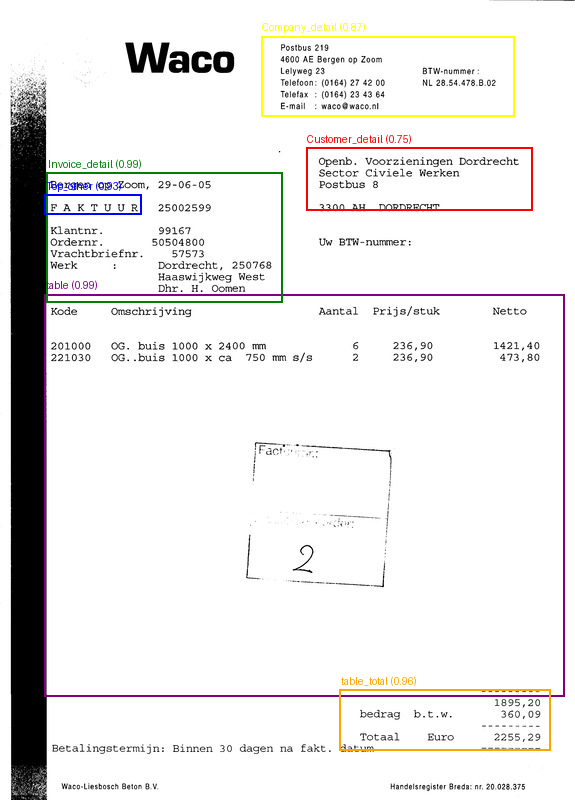

It's Invoice_detail, rotated on 0.0
Bergen op Zoom, 29-06-05
Klantnr. FAKTUUR 25002599
Ordernr. seis?
50504800
Vrachtbriefnr. 57573
Werk Dordrecht, 250768
+ Haaswijkweg West.
Dar. =H. Comen


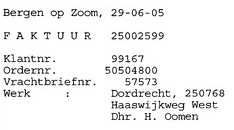

In [4]:
# Создаем парсер
parser = TwoStageParser(cuda=True)

# Тестовое изображение
test_path = "/home/optimus/Desktop/Work/EasyData/Invoice-Parsing/my-script/invoice.JPG"

# Пример использования в разных режимах:
    
# 1. Одностадийный режим с первой стадией
result, predictions = parser.process_image(
    test_path,
    mode="single_stage",
    stage="first"
)
display(result)
test_image = Image.open(test_path)
crops = parser.crop_areas(test_image, predictions, ['Invoice_detail'])
for crop, class_type, coords in crops:
    image = np.array(crop)
    grayscale = image
    # grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    angle = determine_skew(grayscale)
    rotated = rotate(image, angle, (0, 0, 0))
    im_pil = Image.fromarray(rotated)
    print(f"It's {class_type}, rotated on {angle}")

    _, lines = main_algo(im_pil)
    for line in lines:
        print(line)
    display(crop)

In [5]:
import spacy
nlp = spacy.load("/home/optimus/Desktop/Work/EasyData/Invoice-Parsing/my-script/Spacy step/output/model-best")

0.0
Factuurnummer : VKINO50503
Debiteurennummer : DBO0154
Factuurdatum > 30 juni 2005
Uw referentie : DO040226


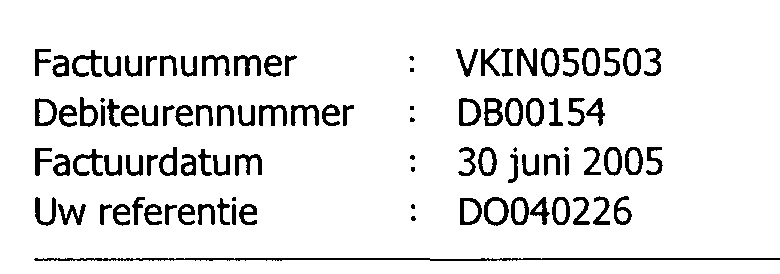

InvoiceNumber: Factuurnummer : VKINO50503
ClientId: Debiteurennummer : DBO0154
InvoiceDate: Factuurdatum > 30 juni 2005


In [6]:
from TextParser.parser import process_image

image = cv2.imread('/home/optimus/Desktop/Work/EasyData/Invoice-Parsing/my-script/Test/0001_001.jpg')
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
angle = determine_skew(grayscale)
print(angle)
rotated = rotate(image, angle, (0, 0, 0))
im_pil = Image.fromarray(rotated)

_, lines = main_algo(im_pil)
for line in lines:
    print(line)

display(im_pil)

text = ' '.join(lines)
doc = nlp(text)

# Выведем извлеченные сущности
for ent in doc.ents:
    print(f"{ent.label_}: {ent.text}")

Here is the extracted text by lines:
[{'text': 'Factuur', 'bbox': [38, 4, 192, 34]}]
[{'text': 'Datum', 'bbox': [44, 63, 92, 22]}]
[{'text': '31 maart 2015', 'bbox': [33, 117, 237, 22]}]
[{'text': 'Factuurnr.', 'bbox': [44, 171, 144, 22]}]
[{'text': '215102', 'bbox': [35, 223, 155, 29]}]
[{'text': 'Uw BTW nr.', 'bbox': [44, 280, 165, 22]}]
[{'text': 'NL.8157.39.308.B01', 'bbox': [33, 335, 297, 22]}]
Here is the extracted text by rows:
[{'text': 'Factuur', 'bbox': [38, 4, 192, 34]}, {'text': 'Datum', 'bbox': [44, 63, 92, 22]}, {'text': '31 maart 2015', 'bbox': [33, 117, 237, 22]}, {'text': 'Factuurnr.', 'bbox': [44, 171, 144, 22]}, {'text': '215102', 'bbox': [35, 223, 155, 29]}, {'text': 'Uw BTW nr.', 'bbox': [44, 280, 165, 22]}, {'text': 'NL.8157.39.308.B01', 'bbox': [33, 335, 297, 22]}]


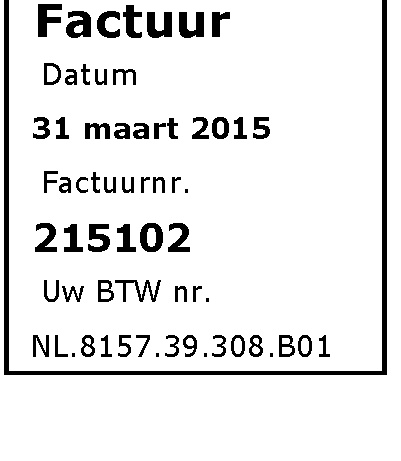

InvoiceDate: Factuur Datum 31 maart 2015
InvoiceNumber: Factuurnr. 215102
ClientVAT: Uw BTW nr. NL.8157.39.308.B01


In [ ]:
from TextParser.parser import process_image

image = cv2.imread('/home/optimus/Desktop/Work/EasyData/Invoice-Parsing/my-script/Test/Factuur 215102 d.d. 31 03 15 Bek en Verburg BV_001.jpg')
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
angle = determine_skew(grayscale)
rotated = rotate(image, angle, (0, 0, 0))
im_pil = Image.fromarray(rotated)

colums, lines = process_image(im_pil)
print('Here is the extracted text by lines:')
txt1 = txt2 = ''
for line in lines:
    print(line)
    for elem in line: txt1 += " " + elem['text']
print('Here is the extracted text by rows:')
for column in colums:
    print(column)
    for elem in column: txt2 += " " + elem['text']

display(im_pil)
doc = nlp(txt1)

# Выведем извлеченные сущности
for ent in doc.ents:
    print(f"{ent.label_}: {ent.text}")

0.0
Here is the extracted text by lines:
[{'text': 'Datum:', 'bbox': [56, 49, 128, 30]}, {'text': 'Ordernummer:', 'bbox': [299, 45, 267, 44]}, {'text': 'Debiteurnummer:', 'bbox': [740, 45, 317, 44]}, {'text': 'Faktuurnummer:', 'bbox': [1205, 48, 301, 30]}]
[{'text': '21/03/14', 'bbox': [56, 109, 160, 30]}, {'text': '526821', 'bbox': [304, 105, 130, 38]}, {'text': '250500', 'bbox': [744, 109, 136, 30]}, {'text': '1071168', 'bbox': [1207, 108, 157, 30]}]
Here is the extracted text by rows:
[{'text': 'Datum:', 'bbox': [56, 49, 128, 30]}, {'text': '21/03/14', 'bbox': [56, 109, 160, 30]}]
[{'text': 'Ordernummer:', 'bbox': [299, 45, 267, 44]}, {'text': '526821', 'bbox': [304, 105, 130, 38]}]
[{'text': 'Debiteurnummer:', 'bbox': [740, 45, 317, 44]}, {'text': '250500', 'bbox': [744, 109, 136, 30]}]
[{'text': 'Faktuurnummer:', 'bbox': [1205, 48, 301, 30]}, {'text': '1071168', 'bbox': [1207, 108, 157, 30]}]


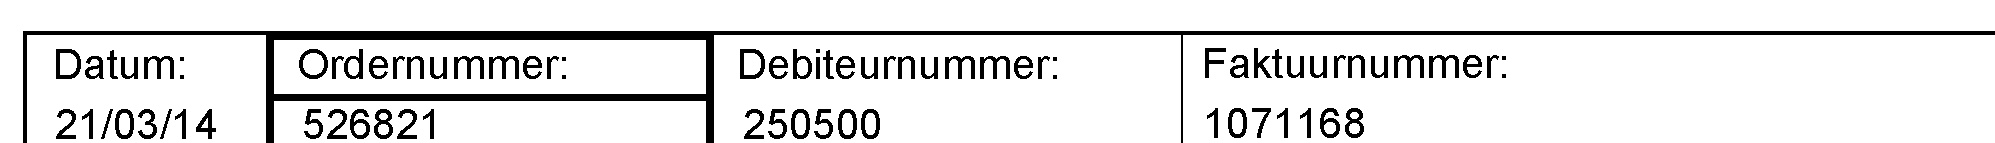

InvoiceDate: Datum: 21/03/14
ClientId: Debiteurnummer: 250500
InvoiceNumber: Faktuurnummer: 1071168


In [25]:
image = cv2.imread('/home/optimus/Desktop/Work/EasyData/Invoice-Parsing/my-script/Test/1071168_002_002.jpg')
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
angle = determine_skew(grayscale)
print(angle)
rotated = rotate(image, angle, (0, 0, 0))
im_pil = Image.fromarray(rotated)

colums, lines = process_image(im_pil)
print('Here is the extracted text by lines:')
txt1 = txt2 = ''
for line in lines:
    print(line)
    for elem in line: txt1 += " " + elem['text']
    txt1 += ' '
print('Here is the extracted text by rows:')
for column in colums:
    print(column)
    for elem in column: txt2 += " " + elem['text']
    txt2 += ' '

display(im_pil)
doc = nlp(txt2)

# Выведем извлеченные сущности
for ent in doc.ents:
    print(f"{ent.label_}: {ent.text}")